In [97]:
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [44]:
# Fetch Haxby dataset participants 1-4
haxby_dataset = datasets.fetch_haxby(subjects=[1, 2, 3, 4])
subjects = [0, 1, 2, 3]

In [33]:
haxby_path[0]

'C:\\Users\\jorda/nilearn_data\\haxby2001\\subj1\\bold.nii.gz'

In [43]:
haxby_dataset.func[0]

'C:\\Users\\jorda/nilearn_data\\haxby2001\\subj1\\bold.nii.gz'

In [71]:
fmri_masked[np.where(condition_idx)[0], :].shape

(864, 23942)

In [154]:
# 1.a Linear SVM for each subject

scores_all = pd.DataFrame()

for subject in subjects:
    
    haxby_path = haxby_dataset.func[subject]
    behavioral = pd.read_csv(haxby_dataset.session_target[subject], sep=" ")
    runs_all = behavioral['chunks'].values
    conditions_all = behavioral['labels'].values
    nruns = len(np.unique(runs_all))

    # select all conditions except rest
    condition_idx = ~behavioral['labels'].isin(['rest'])
    runs = runs_all[condition_idx]
    conditions = conditions_all[condition_idx]

    nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)


    nifti_masker.fit(haxby_path)
    mask_img = nifti_masker.mask_img_
    fmri_masked = nifti_masker.transform(haxby_path)

    cdata = fmri_masked[np.where(condition_idx)[0], :]

    clf = make_pipeline(StandardScaler(), svm.LinearSVC(C=10, penalty='l2',
                    multi_class='ovr', max_iter=5000, class_weight='balanced'))
    fold_acc = np.empty([nruns])
    
    print('*****')
    print('\n Subject ', (subject + 1))
    
    for cfold in range(0, nruns):
        test_data = cdata[np.where(runs == cfold)[0], :]
        test_labels = conditions[np.where(runs == cfold)[0]]
        train_data = cdata[np.where(runs != cfold)[0], :]
        train_labels = conditions[np.where(runs != cfold)[0]]
        cclf = clf.fit(train_data, train_labels)
        fold_acc[cfold] = cclf.score(test_data, test_labels)
        print('Fold: {0:3d}'.format(cfold), end='')
        print(' | {0:6.2f}'.format(fold_acc[cfold]*100), end='%')
        print(' | Done!')
  
    
    scores_all[subject] = fold_acc
    
    
    print('*****')
    print('Final Accuracy: {0:6.2f}'.format(np.mean(fold_acc)*100), end='%')
    print(' ')
    
    

*****

 Subject  1
Fold:   0 |  62.50% | Done!
Fold:   1 |  58.33% | Done!
Fold:   2 |  52.78% | Done!
Fold:   3 |  62.50% | Done!
Fold:   4 |  69.44% | Done!
Fold:   5 |  70.83% | Done!
Fold:   6 |  59.72% | Done!
Fold:   7 |  59.72% | Done!
Fold:   8 |  68.06% | Done!
Fold:   9 |  69.44% | Done!
Fold:  10 |  59.72% | Done!
Fold:  11 |  68.06% | Done!
*****
Final Accuracy:  63.43% 
*****

 Subject  2
Fold:   0 |  38.89% | Done!
Fold:   1 |  45.83% | Done!
Fold:   2 |  56.94% | Done!
Fold:   3 |  43.06% | Done!
Fold:   4 |  62.50% | Done!
Fold:   5 |  63.89% | Done!
Fold:   6 |  55.56% | Done!
Fold:   7 |  58.33% | Done!
Fold:   8 |  58.33% | Done!
Fold:   9 |  59.72% | Done!
Fold:  10 |  59.72% | Done!
Fold:  11 |  58.33% | Done!
*****
Final Accuracy:  55.09% 
*****

 Subject  3
Fold:   0 |  55.56% | Done!
Fold:   1 |  56.94% | Done!
Fold:   2 |  55.56% | Done!
Fold:   3 |  51.39% | Done!
Fold:   4 |  62.50% | Done!
Fold:   5 |  52.78% | Done!
Fold:   6 |  50.00% | Done!
Fold:   7 |  

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, cdata, conditions, cv=5, scoring='roc_auc')

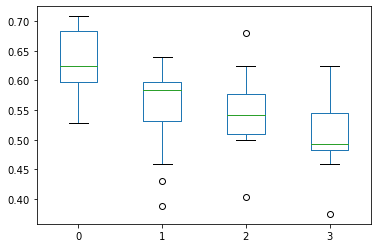

In [147]:
scores_all.plot(kind='box')


In [150]:
# 1.a Logistic Regression for each subject
from sklearn.linear_model import LogisticRegression

scores_logreg = pd.DataFrame()

for subject in subjects:
    
    haxby_path = haxby_dataset.func[subject]
    behavioral = pd.read_csv(haxby_dataset.session_target[subject], sep=" ")
    runs_all = behavioral['chunks'].values
    conditions_all = behavioral['labels'].values
    nruns = len(np.unique(runs_all))

    # select all conditions except rest
    condition_idx = ~behavioral['labels'].isin(['rest'])
    runs = runs_all[condition_idx]
    conditions = conditions_all[condition_idx]

    nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)


    nifti_masker.fit(haxby_path)
    mask_img = nifti_masker.mask_img_
    fmri_masked = nifti_masker.transform(haxby_path)

    cdata = fmri_masked[np.where(condition_idx)[0], :]

    clf = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', solver='sag', max_iter=5000, random_state=42,
                             multi_class='multinomial'))
    
    fold_acc = np.empty([nruns])
    
    print('*****')
    print('\n Subject ', (subject + 1))
    
    for cfold in range(0, nruns):
        test_data = cdata[np.where(runs == cfold)[0], :]
        test_labels = conditions[np.where(runs == cfold)[0]]
        train_data = cdata[np.where(runs != cfold)[0], :]
        train_labels = conditions[np.where(runs != cfold)[0]]
        cclf = clf.fit(train_data, train_labels)
        fold_acc[cfold] = cclf.score(test_data, test_labels)
        print('Fold: {0:3d}'.format(cfold), end='')
        print(' | {0:6.2f}'.format(fold_acc[cfold]*100), end='%')
        print(' | Done!')
        
    scores_logreg[subject] = fold_acc

    print('*****')
    print('Final Accuracy: {0:6.2f}'.format(np.mean(fold_acc)*100), end='%')

    
    

*****

 Subject  1
Fold:   0 |  55.56% | Done!
Fold:   1 |  58.33% | Done!
Fold:   2 |  51.39% | Done!
Fold:   3 |  59.72% | Done!
Fold:   4 |  59.72% | Done!
Fold:   5 |  68.06% | Done!
Fold:   6 |  56.94% | Done!
Fold:   7 |  50.00% | Done!
Fold:   8 |  68.06% | Done!
Fold:   9 |  72.22% | Done!
Fold:  10 |  54.17% | Done!
Fold:  11 |  63.89% | Done!
*****
Final Accuracy:  59.84%*****

 Subject  2
Fold:   0 |  29.17% | Done!
Fold:   1 |  41.67% | Done!
Fold:   2 |  59.72% | Done!
Fold:   3 |  33.33% | Done!
Fold:   4 |  56.94% | Done!
Fold:   5 |  59.72% | Done!
Fold:   6 |  51.39% | Done!
Fold:   7 |  56.94% | Done!
Fold:   8 |  45.83% | Done!
Fold:   9 |  51.39% | Done!
Fold:  10 |  58.33% | Done!
Fold:  11 |  48.61% | Done!
*****
Final Accuracy:  49.42%*****

 Subject  3
Fold:   0 |  54.17% | Done!
Fold:   1 |  58.33% | Done!
Fold:   2 |  51.39% | Done!
Fold:   3 |  50.00% | Done!
Fold:   4 |  55.56% | Done!
Fold:   5 |  40.28% | Done!
Fold:   6 |  38.89% | Done!
Fold:   7 |  48.6

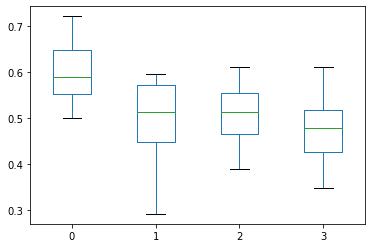

In [151]:
scores_logreg.plot(kind='box')


In [173]:
np.var(np.mean(scores_logreg))

0.0023067772633744875

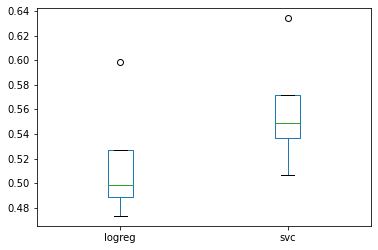

In [171]:
decoding = pd.DataFrame()
decoding['logreg'] = np.mean(scores_logreg)
decoding['svc'] = np.mean(scores_all)
decoding.plot(kind='box')

In [83]:
# 1.b Decoding accuracy for each condition

for subject in subjects:
    
    haxby_path = haxby_dataset.func[subject]
    behavioral = pd.read_csv(haxby_dataset.session_target[subject], sep=" ")
    runs_all = behavioral['chunks'].values
    conditions_all = behavioral['labels'].values
    nruns = len(np.unique(runs_all))

    # select all conditions except rest
    condition_idx = ~behavioral['labels'].isin(['rest'])
    runs = runs_all[condition_idx]
    conditions = conditions_all[condition_idx]

    nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)


    nifti_masker.fit(haxby_path)
    mask_img = nifti_masker.mask_img_
    fmri_masked = nifti_masker.transform(haxby_path)

    cdata = fmri_masked[np.where(condition_idx)[0], :]

    clf = make_pipeline(StandardScaler(), svm.LinearSVC(C=1., penalty='l2',
                    multi_class='ovr', max_iter=5000, class_weight='balanced'))
    
    train_data, test_data, train_labels, test_labels = train_test_split(cdata, conditions, test_size=0.3, random_state=42)
    clf.fit(train_data, train_labels)
    
    # looking at each condition, faces and houses are generally decoded the best
    # results below show precision: true positives / (true positives + false positives)
    # and recall: true positives  / (true positives + false negatives)
    
    print('*****')
    print('\n Subject ', (subject + 1))
    
    pred = clf.predict(test_data)
    print(classification_report(test_labels, pred))

*****

 Subject  1
0.45
              precision    recall  f1-score   support

      bottle       0.33      0.38      0.35        34
         cat       0.44      0.46      0.45        26
       chair       0.21      0.14      0.17        35
        face       0.67      0.71      0.69        28
       house       0.64      0.84      0.73        32
    scissors       0.39      0.31      0.34        39
scrambledpix       0.55      0.57      0.56        30
        shoe       0.31      0.31      0.31        36

    accuracy                           0.45       260
   macro avg       0.44      0.47      0.45       260
weighted avg       0.43      0.45      0.44       260

*****

 Subject  2
0.31153846153846154
              precision    recall  f1-score   support

      bottle       0.14      0.12      0.13        32
         cat       0.13      0.08      0.10        25
       chair       0.27      0.29      0.28        34
        face       0.41      0.42      0.41        31
       house   

In [86]:
# One vs Rest Classifier

for subject in subjects:
    
    haxby_path = haxby_dataset.func[subject]
    behavioral = pd.read_csv(haxby_dataset.session_target[subject], sep=" ")
    runs_all = behavioral['chunks'].values
    conditions_all = behavioral['labels'].values
    nruns = len(np.unique(runs_all))

    # select all conditions except rest
    condition_idx = ~behavioral['labels'].isin(['rest'])
    runs = runs_all[condition_idx]
    conditions = conditions_all[condition_idx]

    nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)


    nifti_masker.fit(haxby_path)
    mask_img = nifti_masker.mask_img_
    fmri_masked = nifti_masker.transform(haxby_path)

    cdata = fmri_masked[np.where(condition_idx)[0], :]

    clf = make_pipeline(StandardScaler(), OneVsRestClassifier(SVC(kernel='linear')))
    fold_acc = np.empty([nruns])
    
    print('*****')
    print('Subject ', (subject + 1))
    
    for cfold in range(0, nruns):
        test_data = cdata[np.where(runs == cfold)[0], :]
        test_labels = conditions[np.where(runs == cfold)[0]]
        train_data = cdata[np.where(runs != cfold)[0], :]
        train_labels = conditions[np.where(runs != cfold)[0]]
        cclf = clf.fit(train_data, train_labels)
        fold_acc[cfold] = cclf.score(test_data, test_labels)
        print('Fold: {0:3d}'.format(cfold), end='')
        print(' | {0:6.2f}'.format(fold_acc[cfold]*100), end='%')
        print(' | Done!')

    print(' ')
    print('Final Accuracy: {0:6.2f}'.format(np.mean(fold_acc)*100), end='%')
    print(' ')
    

*****

 Subject  1
Fold:   0 |  58.33% | Done!
Fold:   1 |  63.89% | Done!
Fold:   2 |  56.94% | Done!
Fold:   3 |  63.89% | Done!
Fold:   4 |  69.44% | Done!
Fold:   5 |  70.83% | Done!
Fold:   6 |  56.94% | Done!
Fold:   7 |  56.94% | Done!
Fold:   8 |  69.44% | Done!
Fold:   9 |  73.61% | Done!
Fold:  10 |  58.33% | Done!
Fold:  11 |  61.11% | Done!
*****
Final Accuracy:  63.31%*****

 Subject  2
Fold:   0 |  38.89% | Done!
Fold:   1 |  44.44% | Done!
Fold:   2 |  63.89% | Done!
Fold:   3 |  38.89% | Done!
Fold:   4 |  61.11% | Done!
Fold:   5 |  62.50% | Done!
Fold:   6 |  58.33% | Done!
Fold:   7 |  59.72% | Done!
Fold:   8 |  51.39% | Done!
Fold:   9 |  59.72% | Done!
Fold:  10 |  63.89% | Done!
Fold:  11 |  50.00% | Done!
*****
Final Accuracy:  54.40%

KeyboardInterrupt: 

In [98]:
# 1.c Hyperparameter tuning


for subject in subjects:
    
    haxby_path = haxby_dataset.func[subject]
    behavioral = pd.read_csv(haxby_dataset.session_target[subject], sep=" ")
    runs_all = behavioral['chunks'].values
    conditions_all = behavioral['labels'].values
    nruns = len(np.unique(runs_all))

    # select all conditions except rest
    condition_idx = ~behavioral['labels'].isin(['rest'])
    runs = runs_all[condition_idx]
    conditions = conditions_all[condition_idx]

    nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)


    nifti_masker.fit(haxby_path)
    mask_img = nifti_masker.mask_img_
    fmri_masked = nifti_masker.transform(haxby_path)

    cdata = fmri_masked[np.where(condition_idx)[0], :]

    clf = Pipeline([('scale', StandardScaler()),
                   ('SVC', svm.LinearSVC())])
    
    
    train_data, test_data, train_labels, test_labels = train_test_split(cdata, conditions, test_size=0.3, random_state=42)
    
    print('Best C value: ')
    print('*****')
    print('\n Subject ', (subject + 1))
    
    param_grid = {'SVC__C': np.arange(0.01,100,10)}
   
    # Grid search to evaluate C values between 0.01 and 100
    linearSVC = GridSearchCV(clf, param_grid, cv=5, return_train_score=True)
    linearSVC.fit(train_data, train_labels)
    print(linearSVC.best_params_)
    print(' ')
    
    

*****

 Subject  1
{'SVC__C': 0.01}
*****

 Subject  2
{'SVC__C': 0.01}
*****

 Subject  3
{'SVC__C': 0.01}
*****

 Subject  4
{'SVC__C': 0.01}


In [100]:
#Problem 2 - How does gamma affect regularization?

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.model_selection import StratifiedShuffleSplit

In [132]:
# Hyperparameter tuning shown just on subject 1 with only faces and houses to reduce computing time

haxby_path = haxby_dataset.func[0]
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
runs_all = behavioral['chunks'].values
conditions_all = behavioral['labels'].values
nruns = len(np.unique(runs_all))

# select all conditions except rest
condition_idx = behavioral['labels'].isin(['face', 'house'])
runs = runs_all[condition_idx]
conditions = conditions_all[condition_idx]

nifti_masker = NiftiMasker(standardize=True, runs=runs_all, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)


nifti_masker.fit(haxby_path)
mask_img = nifti_masker.mask_img_
fmri_masked = nifti_masker.transform(haxby_path)

cdata = fmri_masked[np.where(condition_idx)[0], :]

clf = Pipeline([('scale', StandardScaler()),
                   ('SVC', SVC())])
    
train_data, test_data, train_labels, test_labels = train_test_split(cdata, conditions, test_size=0.3, random_state=42)
    
    
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(SVC__gamma=gamma_range, SVC__C=C_range)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv)
grid.fit(train_data, train_labels)

print("The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_))

The best parameters are {'SVC__C': 10.0, 'SVC__gamma': 1e-05} with a score of 0.90


(151, 23707)

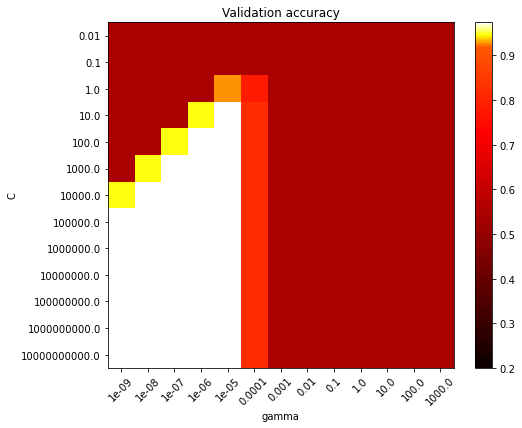

In [131]:
# Visualization of parameter effects

# lower gamma means each training sample has more influence, larger gamma increases overfitting

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()